In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Load the dataset from the local CSV file
df = pd.read_csv("../data/ai_job_dataset.csv")

# Drop rows with missing salary
df = df.dropna(subset=['salary_usd'])

# Confirm environment
print("Python executable in use:", sys.executable)

# Print dimensions (rows, columns)
print("Dataset shape:", df.shape)

# Print column names
print("Column names:", df.columns)

# Show the first few rows
print("First few rows:\n", df.head()) 

# Checking for missing values and summing missing values per column
print("Missing values per column:\n", df.isna().sum())

Python executable in use: c:\Python313\python.exe
Dataset shape: (15000, 19)
Column names: Index(['job_id', 'job_title', 'salary_usd', 'salary_currency',
       'experience_level', 'employment_type', 'company_location',
       'company_size', 'employee_residence', 'remote_ratio', 'required_skills',
       'education_required', 'years_experience', 'industry', 'posting_date',
       'application_deadline', 'job_description_length', 'benefits_score',
       'company_name'],
      dtype='object')
First few rows:
     job_id              job_title  salary_usd salary_currency  \
0  AI00001  AI Research Scientist       90376             USD   
1  AI00002   AI Software Engineer       61895             USD   
2  AI00003          AI Specialist      152626             USD   
3  AI00004           NLP Engineer       80215             USD   
4  AI00005          AI Consultant       54624             EUR   

  experience_level employment_type company_location company_size  \
0               SE        

In [2]:
# Remove salary outliers (top/bottom 1% and 0.1%)
q_low = df['salary_usd'].quantile(0.001)
q_high = df['salary_usd'].quantile(0.99)
df = df[(df['salary_usd'] >= q_low) & (df['salary_usd'] <= q_high)]

In [3]:
# Data cleaning and preparation

# Create num_skills column
df['num_skills'] = df['required_skills'].apply(lambda x: len(str(x).split(',')) if pd.notna(x) else 0)

# *** Attempted to use all features ***
# Combine with other features
features = ['experience_level', 'employment_type', 'job_title', 'employee_residence',
           'company_location', 'company_size', 'remote_ratio']

# Create X and y
X = df[features]
y = df['salary_usd']

# One-hot encode
X = pd.get_dummies(X, drop_first=True)

# *** Attempted to use the 2 strongest figures (Looked like 80% of results) ***
# Use only the two strongest features
#X = df[['years_experience', 'experience_level']]
# One-hot encode experience_level only
#X = pd.get_dummies(X, columns=['experience_level'], drop_first=True)

# Selected top 5 features
#selected_features = [
#    'job_title',
#    'experience_level',
#    'years_experience',
#    'company_size',
#    'benefits_score'
#]

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Models
lin_model = LinearRegression().fit(X_train, y_train)
rf_model = RandomForestRegressor(random_state=42).fit(X_train, y_train)

# Predict
lin_preds = lin_model.predict(X_test)
rf_preds = rf_model.predict(X_test)

# Evaluate
def evaluate_model(y_true, preds, model_name):
    print(f" {model_name} Evaluation")
    print("MAE :", mean_absolute_error(y_true, preds))
    print("RMSE:", np.sqrt(mean_squared_error(y_true, preds)))
    print("R²  :", r2_score(y_true, preds))
    print("")

evaluate_model(y_test, lin_preds, "Linear Regression")
evaluate_model(y_test, rf_preds, "Random Forest Regressor")


 Linear Regression Evaluation
MAE : 15953.40526209043
RMSE: 21010.496869551702
R²  : 0.8561258400384035

 Random Forest Regressor Evaluation
MAE : 15164.80925802344
RMSE: 21035.318965810297
R²  : 0.8557856893187687



In [4]:
# Feature Engineering

# Convert education_required to one-hot
df = pd.get_dummies(df, columns=['education_required'], drop_first=True)

# Create numerical feature: number of listed skills
df['num_skills'] = df['required_skills'].fillna('').apply(lambda x: len(x.split(',')) if x else 0)

# Droped unused long text columns to avoid noise
df = df.drop(columns=['required_skills', 'job_id', 'posting_date', 'application_deadline'])

# Keep useful numeric features
extra_features = ['years_experience', 'job_description_length', 'benefits_score', 'num_skills']

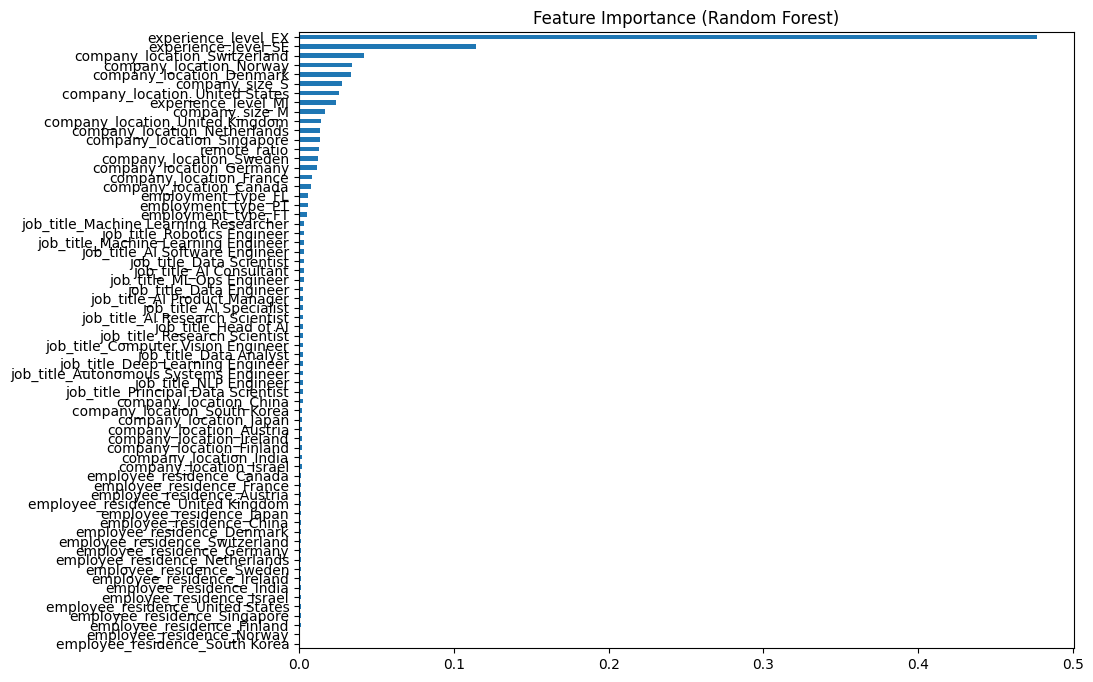

In [5]:
# Linear Regression
lin_model = LinearRegression()
lin_model.fit(X_train, y_train)
lin_preds = lin_model.predict(X_test)

# Random Forest
# Fit Random Forest to get feature importances
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

# Plot feature importances
importances = pd.Series(rf_model.feature_importances_, index=X_train.columns)
importances.sort_values(ascending=True).plot(kind='barh', figsize=(10, 8))
plt.title('Feature Importance (Random Forest)')
plt.show()

In [6]:
# Hyperparameter Tuning for Random Forest 
from sklearn.model_selection import GridSearchCV

# Expanded parameter grid
param_grid = {
    'n_estimators': [200, 500, 1000],
    'max_depth': [10, 20, 40, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

# Grid search with 3-fold cross-validation
grid = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid=param_grid,
    cv=3,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train, y_train)

# Evaluate best model
best_rf = grid.best_estimator_
rf_preds_tuned = best_rf.predict(X_test)

evaluate_model(y_test, rf_preds_tuned, "Tuned Random Forest (Expanded Grid)")


Fitting 3 folds for each of 324 candidates, totalling 972 fits


KeyboardInterrupt: 

In [7]:
# Hyperparameter Tuning for Linear Model
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge

poly_model = make_pipeline(
    PolynomialFeatures(degree=2, include_bias=False),
    Ridge(alpha=1)
)

poly_model.fit(X_train, y_train)
poly_preds = poly_model.predict(X_test)

evaluate_model(y_test, poly_preds, "Polynomial Ridge Regression")

 Polynomial Ridge Regression Evaluation
MAE : 14966.44597065706
RMSE: 20032.77183340653
R²  : 0.8692046681441279



In [8]:
# Interpret model outputs 
def evaluate_model(y_true, preds, model_name):
    print(f" {model_name} Evaluation")
    print("MAE :", mean_absolute_error(y_true, preds))
    print("RMSE:", np.sqrt(mean_squared_error(y_true, preds)))
    print("R²  :", r2_score(y_true, preds))
    print("")

evaluate_model(y_test, lin_preds, "Linear Regression")
evaluate_model(y_test, rf_preds, "Random Forest Regressor")

 Linear Regression Evaluation
MAE : 15953.40526209043
RMSE: 21010.496869551702
R²  : 0.8561258400384035

 Random Forest Regressor Evaluation
MAE : 15164.80925802344
RMSE: 21035.318965810297
R²  : 0.8557856893187687



In [9]:
# Summary statistics for numerical columns
print(df.describe())

# Summary for all columns including categorical
print(df.info())

          salary_usd  remote_ratio  years_experience  job_description_length  \
count   14835.000000  14835.000000      14835.000000            14835.000000   
mean   113193.885878     49.440512          6.176677             1503.171217   
std     56217.533769     40.830627          5.504199              576.240055   
min     33127.000000      0.000000          0.000000              500.000000   
25%     70011.500000      0.000000          2.000000             1003.000000   
50%     98968.000000     50.000000          4.000000             1512.000000   
75%    144630.000000    100.000000          9.000000             2000.500000   
max    307774.000000    100.000000         19.000000             2499.000000   

       benefits_score    num_skills  
count    14835.000000  14835.000000  
mean         7.503546      3.993664  
std          1.450040      0.816252  
min          5.000000      3.000000  
25%          6.200000      3.000000  
50%          7.500000      4.000000  
75%          

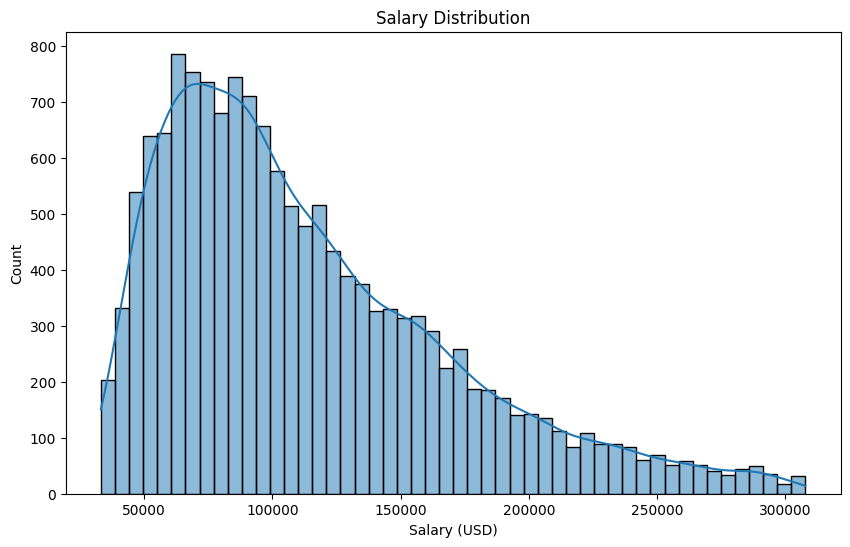

In [10]:
# Distribution of salary_usd
plt.figure(figsize=(10, 6))
sns.histplot(df['salary_usd'], bins=50, kde=True)
plt.title('Salary Distribution')
plt.xlabel('Salary (USD)')
plt.ylabel('Count')
plt.show()

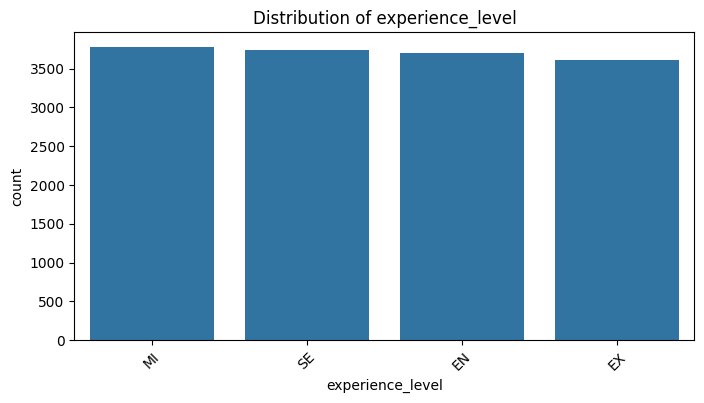

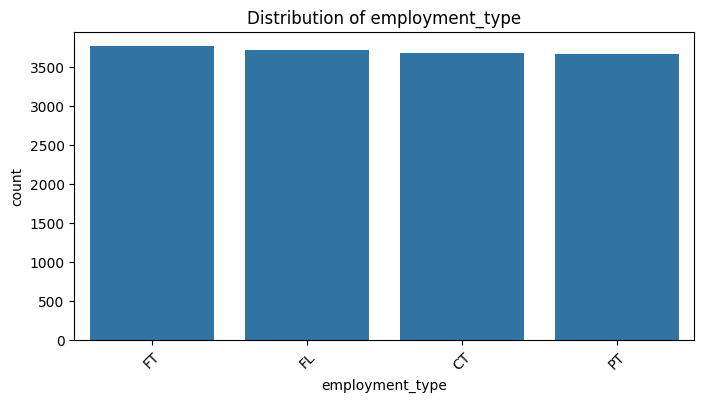

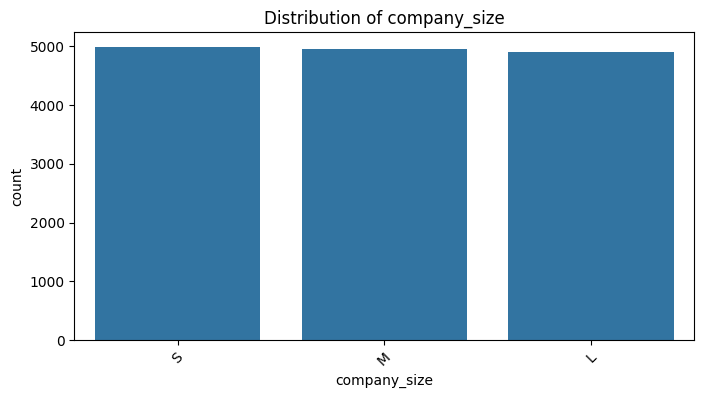

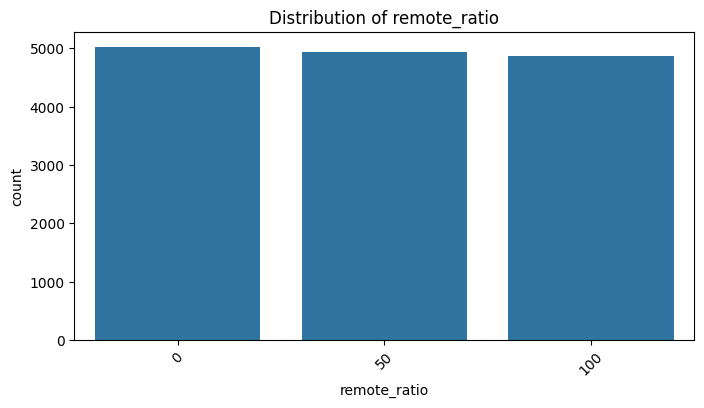

In [11]:
# Distribution of categorial features
categorical_features = ['experience_level', 'employment_type', 'company_size', 'remote_ratio']

for feature in categorical_features:
    plt.figure(figsize=(8, 4))
    sns.countplot(data=df, x=feature, order=df[feature].value_counts().index)
    plt.title(f'Distribution of {feature}')
    plt.xticks(rotation=45)
    plt.show()

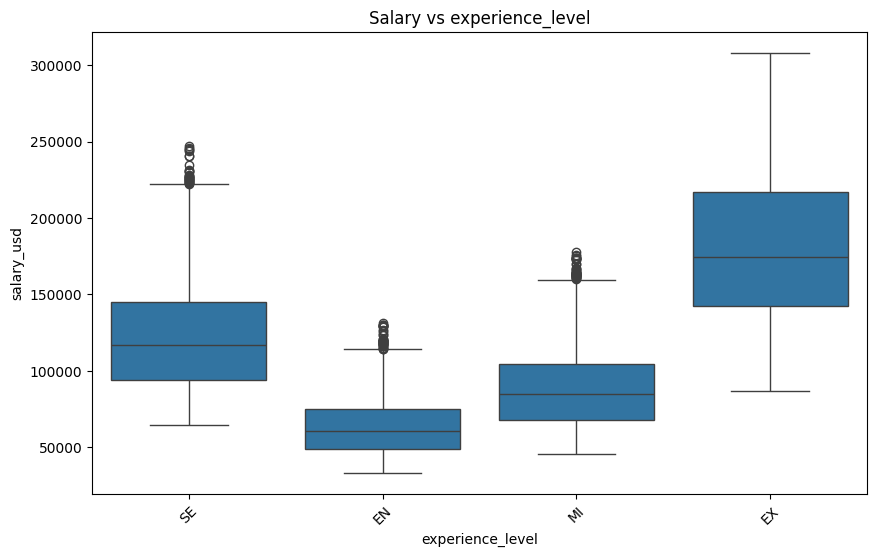

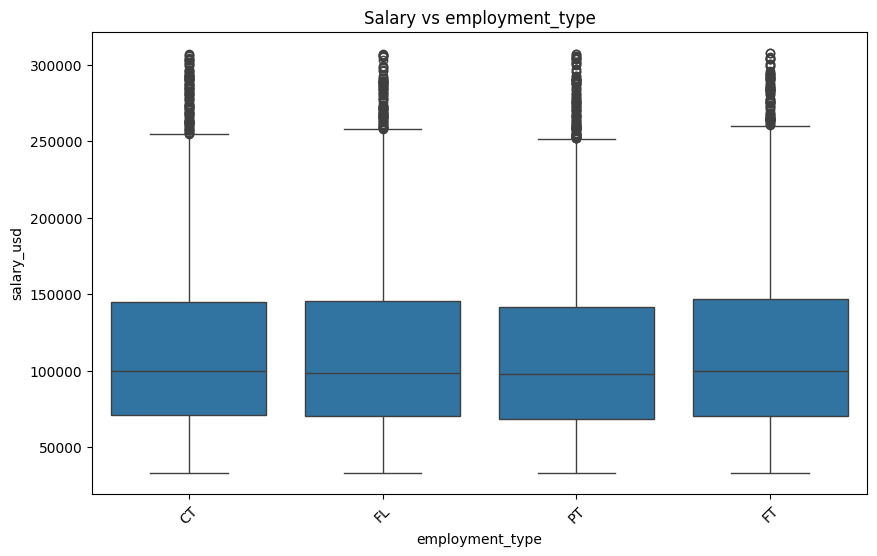

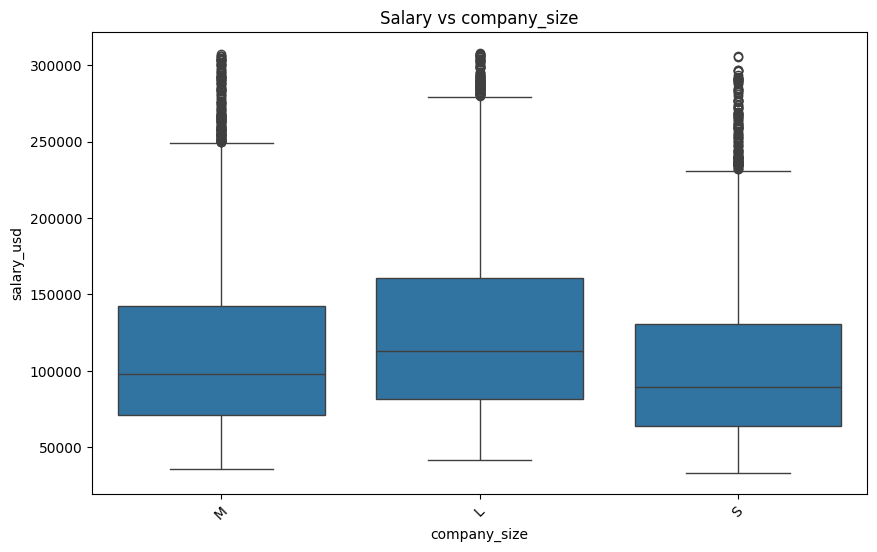

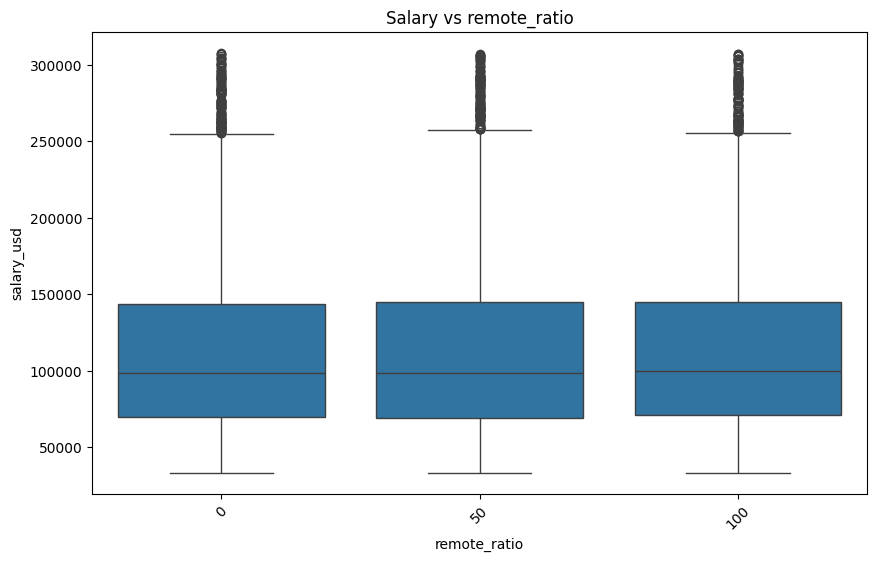

In [12]:
# Boxplot of salary vs categorial features
for feature in categorical_features:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=feature, y='salary_usd', data=df)
    plt.title(f'Salary vs {feature}')
    plt.xticks(rotation=45)
    plt.show()

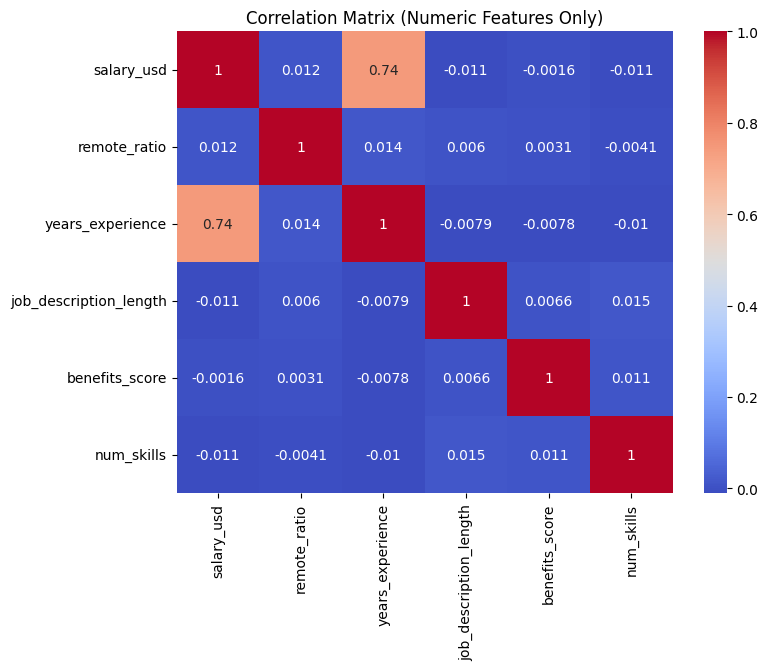

In [13]:
# Correlation heatmap of numerical features

# Select only numeric columns
numeric_df = df.select_dtypes(include=[np.number])

plt.figure(figsize=(8, 6))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix (Numeric Features Only)')
plt.show()

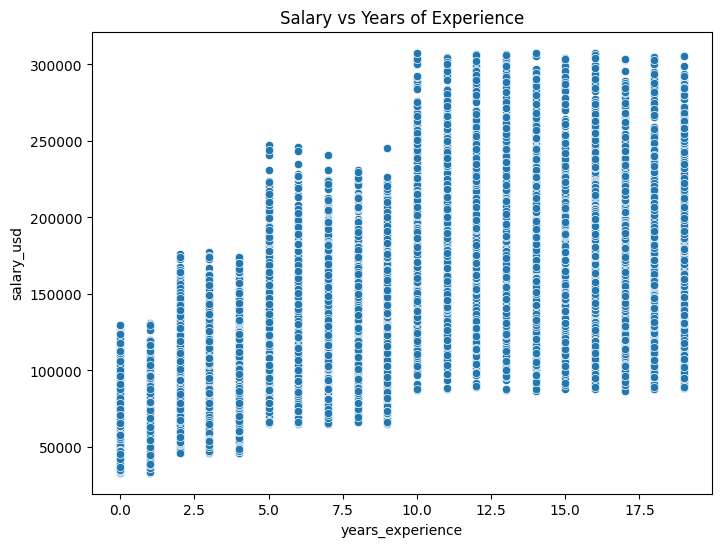

In [14]:
# Scatterplot for nymerical relationships
plt.figure(figsize=(8, 6))
sns.scatterplot(x='years_experience', y='salary_usd', data=df)
plt.title('Salary vs Years of Experience')
plt.show()

C:\Users\blake\AppData\Local\Temp\ipykernel_133152\3115762014.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df, x='Model', y='R² Score', palette='Set2')


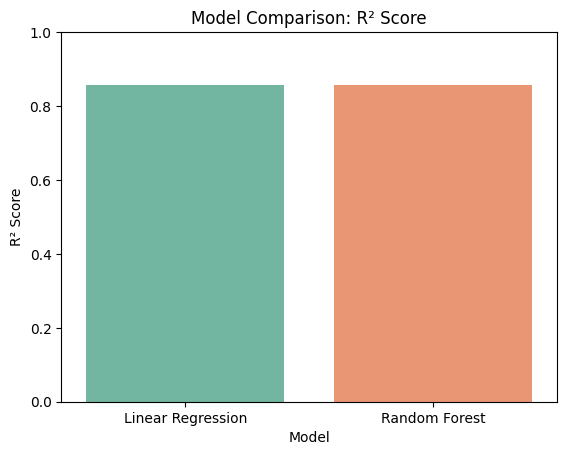

In [15]:
# Compare model R^2 scores
results = {
    'Model': ['Linear Regression', 'Random Forest'],
    'R² Score': [r2_score(y_test, lin_preds), r2_score(y_test, rf_preds)]
}
results_df = pd.DataFrame(results)

# Plot
sns.barplot(data=results_df, x='Model', y='R² Score', palette='Set2')
plt.title('Model Comparison: R² Score')
plt.ylim(0, 1)
plt.show()

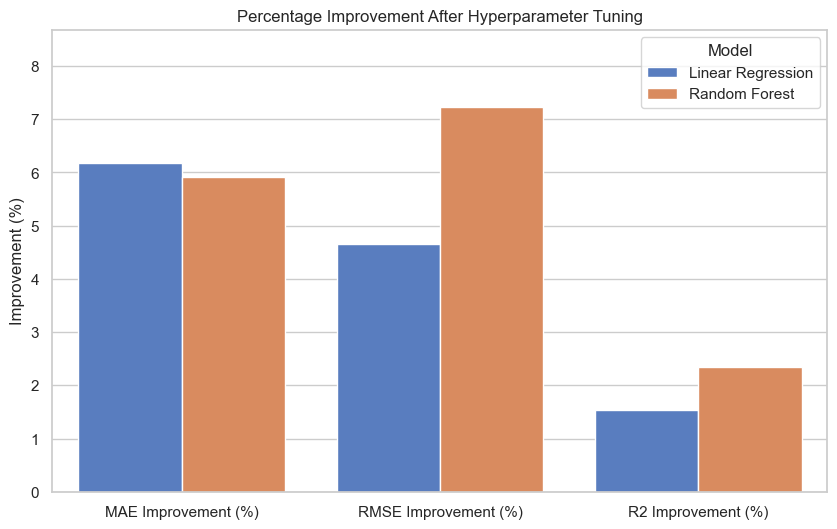

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Original and tuned scores
data = {
    'Model': ['Linear Regression', 'Random Forest'],
    'MAE Before': [15953.41, 15164.81],
    'MAE After': [14966.45, 14268.83],

    'RMSE Before': [21010.50, 21035.32],
    'RMSE After': [20032.77, 19513.56],

    'R2 Before': [0.8561, 0.8558],
    'R2 After': [0.8692, 0.8759]
}
df = pd.DataFrame(data)

# Calculate % improvement for error metrics (lower is better)
df['MAE Improvement (%)'] = 100 * (df['MAE Before'] - df['MAE After']) / df['MAE Before']
df['RMSE Improvement (%)'] = 100 * (df['RMSE Before'] - df['RMSE After']) / df['RMSE Before']
# For R2, higher is better, so calculate increase
df['R2 Improvement (%)'] = 100 * (df['R2 After'] - df['R2 Before']) / df['R2 Before']

# Melt for plotting
results_long = df.melt(id_vars='Model', value_vars=['MAE Improvement (%)', 'RMSE Improvement (%)', 'R2 Improvement (%)'],
                       var_name='Metric', value_name='Improvement')

sns.set(style="whitegrid")

plt.figure(figsize=(10,6))
sns.barplot(data=results_long, x='Metric', y='Improvement', hue='Model', palette='muted')

plt.title('Percentage Improvement After Hyperparameter Tuning')
plt.ylabel('Improvement (%)')
plt.xlabel('')
plt.ylim(0, results_long['Improvement'].max() * 1.2)  # Add some padding

plt.show()